In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 86.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install py7zr rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=a0f489d73935df66c0e5cd59a7a3c744f46e82e3f1f89b95276cc70f6580c027
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


## Load dataset

Link dataset *samsum* [here](https://huggingface.co/datasets/samsum).

In [ ]:
from datasets import load_dataset

train_ds, val_ds, test_ds = load_dataset("samsum", split=['train', 'validation', 'test'])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Dataset samsum downloaded and prepared to /root/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_ds

Dataset({
    features: ['id', 'dialogue', 'summary'],
    num_rows: 14732
})

In [ ]:
print("Number of training examples:", len(train_ds))
print("Number of validation examples:", len(val_ds))
print("Number of test examples:", len(test_ds))

Number of training examples: 14732
Number of validation examples: 818
Number of test examples: 819


Let's look at an example:

In [ ]:
example = train_ds[0]
content = example['dialogue']
summary = example['summary']
print("Content:", content)
print("Summary:", summary)

Content: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda baked cookies and will bring Jerry some tomorrow.


## Encode the dataset

The T5 model or Bart model, like any other Transformer model, does not directly expect text as input. Rather, it expects `input_ids` and `attention_mask`. The `input_ids` are integer vocabulary indices of the tokens of the text. As labels, it expects the `input_ids` of the summary. 

In [ ]:
from transformers import BartTokenizer, T5Tokenizer

Btokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
Ttokenizer = T5Tokenizer.from_pretrained("t5-base")

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
# prefix = "Summarize: "
max_input_length = 512
max_target_length = 64

In [ ]:
def preprocess_examples(examples, tokenizer):
  # encode the documents
  contents = examples['dialogue']
  summaries = examples['summary']
  
  model_inputs = tokenizer(contents, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)
  
  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

In [ ]:
def encode(tokenizer):
  encoded_train_ds = train_ds.map(lambda x: preprocess_examples(x, tokenizer), batched=True, remove_columns=train_ds.column_names)
  encoded_val_ds = val_ds.map(lambda x: preprocess_examples(x, tokenizer), batched=True, remove_columns=val_ds.column_names)
  # encoded_test_ds = test_ds.map(lambda x: preprocess_examples(x, tokenizer), batched=True, remove_columns=test_ds.column_names)
  return encoded_train_ds, encoded_val_ds

In [ ]:
encoded_train_ds_T, encoded_val_ds_T = encode(Ttokenizer)
encoded_train_ds_B, encoded_val_ds_B = encode(Btokenizer)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Format to PyTorch.

In [ ]:
encoded_train_ds_T.set_format(type="torch")
encoded_val_ds_T.set_format(type="torch")
# encoded_test_ds_T.set_format(type="torch")
#----------------------------------------#
encoded_train_ds_B.set_format(type="torch")
encoded_val_ds_B.set_format(type="torch")
# encoded_test_ds_B.set_format(type="torch")

Create PyTorch dataloaders.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
def create_dataloaders(encoded_train_ds, encoded_val_ds, train_batch_size=8, eval_batch_size=32):
    train_dataloader = DataLoader(encoded_train_ds, shuffle=True, batch_size=train_batch_size)
    val_dataloader = DataLoader(encoded_val_ds, shuffle=False, batch_size=eval_batch_size)
    return train_dataloader, val_dataloader

## Fine-tune a model 

Below, we define a `training_function`, which defines a regular training loop in native PyTorch. We only need to add a few lines to make sure the code will run on TPU. The Accelerator object will take care of that. Basically, the model as well as the data will be replicated across each of the 8 TPU cores. 

We also define a dictionary of training-related hyperparameters, which we can easily tweak.

In [ ]:
hyperparameters_T = {
    "learning_rate": 0.0001,
    "num_epochs": 5,
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "seed": 42,
    "patience": 1, # early stopping
    "output_dir": "/content/drive/MyDrive/Deep Learning/52000734_52000768/T5",
}
#-------------------------------------------------------------------------------------------#
hyperparameters_B = {
    "learning_rate": 0.0001,
    "num_epochs": 5,
    "train_batch_size": 2,
    "eval_batch_size": 2,
    "seed": 42,
    "patience": 1, # early stopping
    "output_dir": "/content/drive/MyDrive/Deep Learning/52000734_52000768/Bart",
}

In [ ]:
import torch
from transformers import BartForConditionalGeneration, T5ForConditionalGeneration, AdamW, set_seed
from accelerate import Accelerator
from tqdm.notebook import tqdm
import datasets
import transformers

In [ ]:
def training_function(model, encoded_train_ds, encoded_val_ds, hyperparameters):
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    # The seed need to be set before we instantiate the model, as it will determine the random head.
    set_seed(hyperparameters["seed"])

    # Instantiate optimizer
    optimizer = AdamW(model.parameters(), lr=hyperparameters["learning_rate"])

    # Prepare everything
    train_dataloader, val_dataloader = create_dataloaders(
        encoded_train_ds, encoded_val_ds, train_batch_size=hyperparameters["train_batch_size"], eval_batch_size=hyperparameters["eval_batch_size"]
    )
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, optimizer, train_dataloader, val_dataloader = accelerator.prepare(model, optimizer, 
                                                                             train_dataloader, val_dataloader)
    
    # train the model
    epochs_no_improve = 0
    min_val_loss = 1000000
    for epoch in range(hyperparameters["num_epochs"]):
        # We only enable the progress bar on the main process to avoid having 8 progress bars.
        progress_bar = tqdm(range(len(train_dataloader)), disable=not accelerator.is_main_process)
        progress_bar.set_description(f"Epoch: {epoch}")
        model.train()
        for batch in train_dataloader:
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)
            
            optimizer.step()
            optimizer.zero_grad()
            progress_bar.set_postfix({'loss': loss.item()})
            progress_bar.update(1)

        # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
        model.eval()
        validation_losses = []
        for batch in val_dataloader:
            with torch.no_grad():
                outputs = model(**batch)
            loss = outputs.loss

            # We gather the loss from the 8 TPU cores to have them all.
            validation_losses.append(accelerator.gather(loss[None]))

        # Compute average validation loss
        val_loss = torch.stack(validation_losses).sum().item() / len(validation_losses)
        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}: validation loss:", val_loss)
        if val_loss < min_val_loss:
          epochs_no_improve = 0
          min_val_loss = val_loss
          continue
        else:
          epochs_no_improve += 1
          # Check early stopping condition
          if epochs_no_improve == hyperparameters["patience"]:
            accelerator.print("Early stopping!")
            break

    # save trained model
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    # Use accelerator.save to save
    unwrapped_model.save_pretrained(hyperparameters["output_dir"], save_function=accelerator.save)

Next, we can easily start training by wrapping the `training_function` in a `notebook_launcher`.

In [ ]:
from accelerate import notebook_launcher
Bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
T5_model = T5ForConditionalGeneration.from_pretrained('T5-base')

In [ ]:
notebook_launcher(training_function(Bart_model, encoded_train_ds_B, encoded_val_ds_B, hyperparameters_B))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7366 [00:00<?, ?it/s]

epoch 0: validation loss: 0.8549831548937958


  0%|          | 0/7366 [00:00<?, ?it/s]

epoch 1: validation loss: 0.8499664828946363


  0%|          | 0/7366 [00:00<?, ?it/s]

Configuration saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/Bart/config.json
Configuration saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/Bart/generation_config.json


epoch 2: validation loss: 0.8565185099184367
Early stopping!


Model weights saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/Bart/pytorch_model.bin


Launching training on one GPU.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/accelerate/launchers.py:103 in notebook_launcher         │
│                                                                                                  │
│   100 │   │   │   print("Launching training on one GPU.")                                        │
│   101 │   │   else:                                                                              │
│   102 │   │   │   print("Launching training on one CPU.")                                        │
│ ❱ 103 │   │   function(*args)                                                                    │
│   104 │   else:                                                                                  │
│   105 │   │   if num_processes is None:                                                          │
│   106 │   │   │   raise ValueError(                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not callable

In [ ]:
notebook_launcher(training_function(T5_model, encoded_train_ds_T, encoded_val_ds_T, hyperparameters_T)) 

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/7366 [00:00<?, ?it/s]

epoch 0: validation loss: 1.4063598334352079


  0%|          | 0/7366 [00:00<?, ?it/s]

epoch 1: validation loss: 1.3932225010505808


  0%|          | 0/7366 [00:00<?, ?it/s]

Configuration saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/T5/config.json
Configuration saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/T5/generation_config.json


epoch 2: validation loss: 1.4107164602116442
Early stopping!


Model weights saved in /content/drive/MyDrive/Deep Learning/52000734_52000768/T5/pytorch_model.bin


Launching training on one GPU.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/accelerate/launchers.py:103 in notebook_launcher         │
│                                                                                                  │
│   100 │   │   │   print("Launching training on one GPU.")                                        │
│   101 │   │   else:                                                                              │
│   102 │   │   │   print("Launching training on one CPU.")                                        │
│ ❱ 103 │   │   function(*args)                                                                    │
│   104 │   else:                                                                                  │
│   105 │   │   if num_processes is None:                                                          │
│   106 │   │   │   raise ValueError(                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'NoneType' object is not callable

## Evaluate


In [ ]:
Bart_model_trained = BartForConditionalGeneration.from_pretrained(hyperparameters_B["output_dir"])
T5_model_trained = T5ForConditionalGeneration.from_pretrained(hyperparameters_T["output_dir"])

loading configuration file /content/drive/MyDrive/Deep Learning/52000734_52000768/Bart/config.json
Model config BartConfig {
  "_name_or_path": "facebook/bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decod

In [ ]:
def encode_test_dataloader(examples, tokenizer):
  # encode the documents
  contents = examples['dialogue']
  summaries = examples['summary']
  
  model_inputs = tokenizer(contents, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(summaries, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  model_inputs['labels'] = labels
  return model_inputs

In [ ]:
test_ds_T = test_ds.map(lambda x: encode_test_dataloader(x, Ttokenizer), batched=True, remove_columns=test_ds.column_names)
test_ds_B = test_ds.map(lambda x: encode_test_dataloader(x, Btokenizer), batched=True, remove_columns=test_ds.column_names)

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

In [ ]:
test_ds_T.set_format(type="torch")
test_ds_B.set_format(type="torch")

In [ ]:
encoded_test_dataloader_T = DataLoader(test_ds_T, shuffle=False, batch_size=32)
encoded_test_dataloader_B = DataLoader(test_ds_B, shuffle=False, batch_size=32)

In [ ]:
def testing_function(model, test_dataloader):
    # Initialize accelerator
    accelerator = Accelerator()

    # To have only one message (and not 8) per logs of Transformers or Datasets, we set the logging verbosity
    # to INFO for the main process only.
    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()
    # There is no specific order to remember, we just need to unpack the objects in the same order we gave them to the
    # prepare method.
    model, test_dataloader = accelerator.prepare(model, test_dataloader)
        # Evaluate at the end of the epoch (distributed evaluation as we have 8 TPU cores)
    model.eval()
    test_losses = []
    for batch_idx, batch in tqdm(enumerate(test_dataloader)):
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        # We gather the loss from the 8 TPU cores to have them all.
        test_losses.append(accelerator.gather(loss[None]))
        if(batch_idx % 10 == 0):
          # Compute average test loss
          test_loss = torch.stack(test_losses).sum().item() / len(test_losses)
          # Use accelerator.print to print only on the main process.
          accelerator.print(f"No. {batch_idx} - test_loss:", test_loss)
    return torch.stack(test_losses).sum().item() / len(test_losses)

In [ ]:
test_loss_Bart = testing_function(Bart_model_trained, encoded_test_dataloader_B)

0it [00:00, ?it/s]

No. 0 - test_loss: 1.1242109537124634
No. 10 - test_loss: 0.9836890480735085
No. 20 - test_loss: 0.9942675090971447


In [ ]:
test_loss_T5 = testing_function(T5_model_trained, encoded_test_dataloader_T)

0it [00:00, ?it/s]

No. 0 - test_loss: 14.61937141418457
No. 10 - test_loss: 16.61111727627841
No. 20 - test_loss: 16.45157441638765


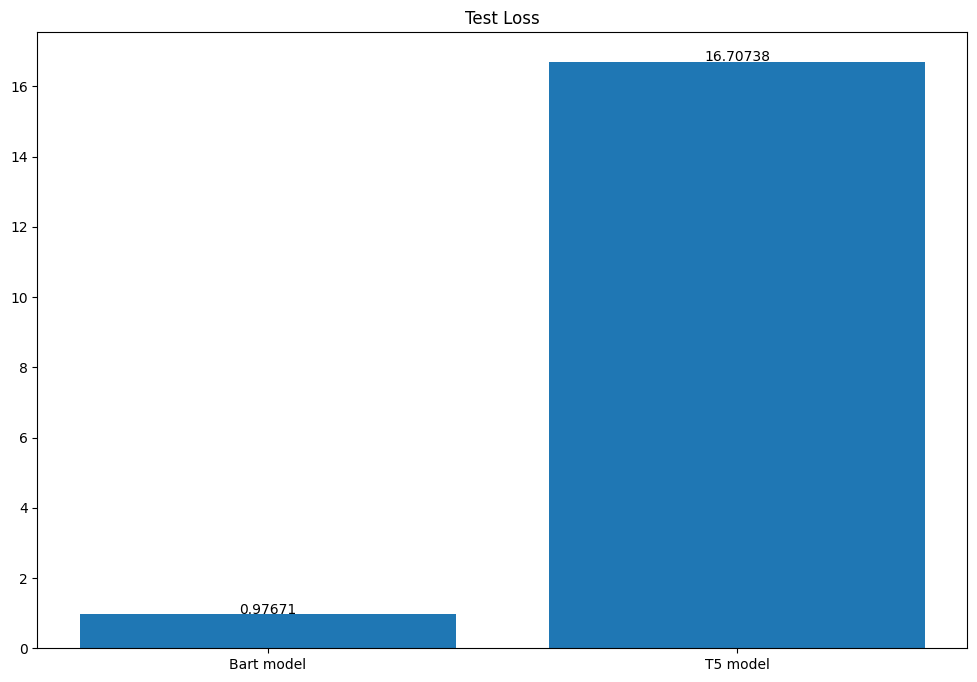

In [ ]:
from matplotlib import pyplot as plt

models = ['Bart model', 'T5 model']
scores = [test_loss_Bart, test_loss_T5]
plt.figure(figsize=(12, 8))
plt.bar(models, scores)

for i, score in enumerate(scores):
    plt.text(i, score+0.01, str(round(score, 5)), ha='center')

plt.title('Test Loss')
plt.show()


In [ ]:
#test orther text doesn't have in dataset
def encode_text(examples, tokenizer):
    # Encode the text using the tokenizer
    contents = examples['text']
    titles = examples['title']
    inputs = [title + content for title, content in zip(titles, contents)]
    encoding = tokenizer.encode_plus(
        inputs,
        max_length=max_input_length,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding["input_ids"], encoding["attention_mask"]

def generate_summary(model, input_ids, attention_mask):
    # Generate a summary using the best model
    generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_target_length,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    return generated_ids

def decode_summary(generated_ids, tokenizer):
    # Decode the generated summary
    summary = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
               for gen_id in generated_ids]
    return "".join(summary)

def summarize(model, text, tokenizer):
    input_ids, attention_mask = encode_text(text, tokenizer)
    generated_ids = generate_summary(model, input_ids, attention_mask)
    summary = decode_summary(generated_ids, tokenizer)
    return summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
def evaluate_model(model, tokenizer, test_dataloader):
    rouge_scores = 0
    model.to(device)
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        generate_ids = model.generate(
            input_ids=input_ids,
            do_sample=True,
            max_length=max_target_length,
            top_k=0,
            temperature=0.7,
            early_stopping=True
        )
        summary = ' '.join([tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generate_ids])
        reference = ' '.join([tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in labels])
        rouge = scorer.score(reference, summary)
        rouge_scores += rouge['rougeL'][-1]
    return rouge_scores/len(test_dataloader)

In [ ]:
Rouge_score_Bart = evaluate_model(Bart_model_trained, Btokenizer, encoded_test_dataloader_B)

  0%|          | 0/26 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1,
  "transformers_version": "4.28.1"
}

Generate config Genera

In [ ]:
Rouge_score_T5 = evaluate_model(T5_model_trained, Ttokenizer, encoded_test_dataloader_T)

  0%|          | 0/26 [00:00<?, ?it/s]

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.28.1"
}

Generate config GenerationConfig {
  "_from_model_config": true,
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "

In [ ]:
print(Rouge_score_Bart, Rouge_score_T5)

0.36417737151625496 0.36578791171172836


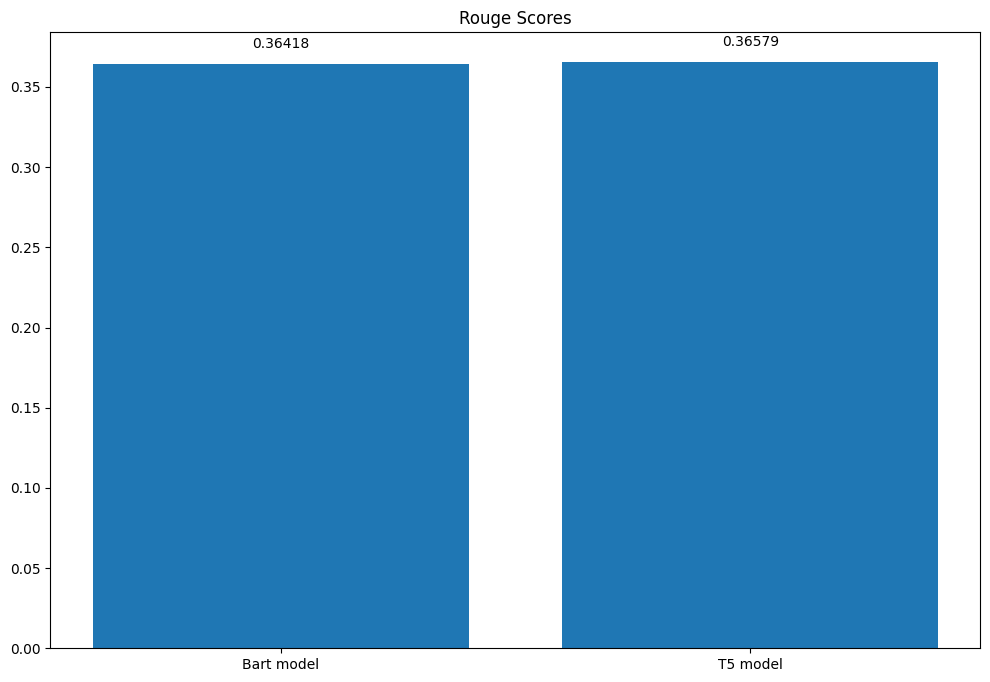

In [ ]:
from matplotlib import pyplot as plt

models = ['Bart model', 'T5 model']
scores = [Rouge_score_Bart, Rouge_score_T5]
plt.figure(figsize=(12, 8))
plt.bar(models, scores)

for i, score in enumerate(scores):
    plt.text(i, score+0.01, str(round(score, 5)), ha='center')

plt.title('Rouge Scores')
plt.show()
